<h1 style="background:#6A9662; color:#FFF; padding:5px;">Business Analytics with Python</h1>

# <font color='#6A9662'>Marketing Analytics</font>

##  Segmentação de clientes de *Food Delivery*

![title](imagens/segmentation.png)

<h3 style="background:#6A9662; color:#FFF; padding:5px;">0. Sumário executivo</h3>

#### 1. Sobre o *The Ninga*
O restaurante *The Ninga* está presente em 6 estados brasileiros, principalmente nas regiões Sul e Sudeste. Especializado em entregas de refeições 24 horas por dia em todos os dias da semana.


#### 2. Desafio de negócio
O mercado de *food delivery* vem crescendo ano após ano, muito impulsionado por mudanças no hábito de consumo do brasileiro e com a constante necessidade de maximizar o tempo a opção de solicitar refeições por telefone ou app tem se mostrado satisfatória.

Com esse crescimento e novos hábitos de consumo, as lojas dos restaurantes *The Ninga* ganharam uma atenção ainda maior, uma vez que, as refeições precisam estar à disposição do cliente nos momentos que eles necessitam. Além disso a concorrência nas grandes cidades onde as lojas do *The Ninga* estão estabelecidas vem aumentando signicativamente, exigindo valores mais competitivos e entregas cada vez mais rápidas.


#### 3. Objetivo da análise
O departamento de marketing da *The Ninga* requer um melhor conhecimento de seus clientes,  para isso necessitam de uma segmentação baseada nos últimos 10.000 pedidos. As informações dos pedidos estão agrupadas por famílias de produtos. Espera-se com isso:

- Criar três campanhas de marketing para aumentar as vendas de pizza nos meses de Janeiro, Fevereiro, Junho e Julho.
- Implantar 4 campanhas, usando a variável períodos (manhã, tarde, noite e madrugada) respectivamente a fim de maximizar a venda de pizzas.

<h3 style="background:#6A9662; color:#FFF; padding:5px;">1. Carregando os pacotes</h3>

In [1]:
# Tools to Analysis
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning to clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Wecchi Data Science" --iversions

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Author: Wecchi Data Science

matplotlib: 3.3.1
pandas    : 1.2.1
sklearn   : 0.23.1
numpy     : 1.19.2
seaborn   : 0.10.1



<h3 style="background:#6A9662; color:#FFF; padding:5px;">2. Carregando os dados dos pedidos</h3>

#### Dicionário de Dados

|Variável|Descrição|
|:------|:---------|
|id_transacao|ID da transação. Um mesmo ID pode ter vários itens de um pedido.|
|horario_pedido|Horário exato do pedido.|
|localidade|Localidade que processou o pedido (unidade do restaurante).|
|nome_item|Nome do item (pizza, salada, bebida e sobremesa).|
|quantidade_item|Quantidade de itens no pedido.|
|latitude|Latitude da localidadeonde o pedido foi gerado.|
|longitude|Longitude da localidadeonde o pedido foi gerado|

In [2]:
df_food_delivery = pd.read_csv("dados/dataset.csv", encoding = 'utf-8')
df_food_delivery.shape

(260645, 7)

In [3]:
df_food_delivery.head(5)

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


In [4]:
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [5]:
# Verificando o total de valores únicos por coluna - lembrando que temos 260.645 linhas no dataset
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [6]:
# Verificando existência de valores nulos
df_food_delivery.isna().any()

id_transacao       False
horario_pedido     False
localidade         False
nome_item          False
quantidade_item    False
latitude           False
longitude          False
dtype: bool

<h3 style="background:#6A9662; color:#FFF; padding:5px;">3. Análise exploratória</h3>

In [7]:
# Resumo das colunas numéricas (não se aplica para variáveis do tipo string)
df_food_delivery.describe()

,localidade,quantidade_item,latitude,longitude
count,260645.000000,260645.000000,260645.000000,260645.000000
mean,5.134904,2.447010,41.836095,-87.733930
std,2.551846,1.330863,0.144459,0.136369
min,1.000000,1.000000,41.524598,-88.010140
25%,3.000000,1.000000,41.784576,-87.849468
50%,5.000000,2.000000,41.881818,-87.677606
75%,7.000000,4.000000,41.889047,-87.627059
max,9.000000,5.000000,42.049306,-87.607565


(array([87307., 59409., 45455., 47059., 21415.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

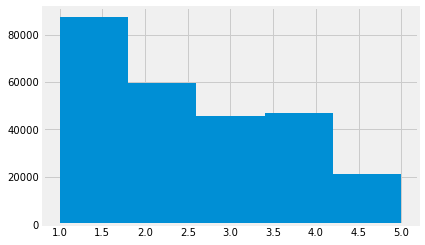

In [8]:
# Histograma das quantidades pedidas
plt.hist(df_food_delivery.quantidade_item, bins = 5)

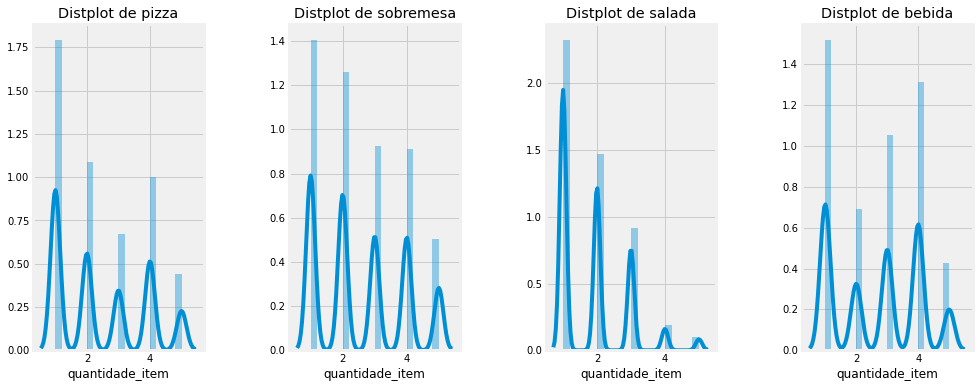

In [9]:
# Tamanho da figura
plt.figure(1 , figsize = (15 , 6))

# Inicializa o contador
n = 0 

# Loop pelas colunas
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    n += 1
    plt.subplot(1 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df_food_delivery.quantidade_item[df_food_delivery.nome_item == x] , bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()

<h3 style="background:#6A9662; color:#FFF; padding:5px;">4. Pré-processamento dos dados</h3>

In [10]:
# Vamos criar uma tabela pivot com id_transacao, nome_item e quantidade_item
df_pivot = df_food_delivery.pivot_table(index = ['id_transacao'], columns = ['nome_item'], values = 'quantidade_item')

In [11]:
# Substituímos possíveis valores NA gerados no pivot, por 0 e transformamos o índice em coluna
df_pivot = df_pivot.fillna(0).reset_index()

In [12]:
df_pivot.head(5)

nome_item,id_transacao,bebida,pizza,salada,sobremesa
0,0x10000a,0.0,1.0,0.0,1.0
1,0x100058,0.0,2.0,0.0,2.0
2,0x1000c8,4.0,4.0,1.0,5.0
3,0x10014c,0.0,1.0,0.0,1.0
4,0x1001d8,3.0,3.0,0.0,3.0


In [13]:
# Vamos incluir a coluna horário e localidade para fazer o merge uso id_transacao
df_item_pedidos = df_pivot.merge(df_food_delivery[['id_transacao', 'horario_pedido', 'localidade']])

In [14]:
df_item_pedidos.head(5)

,id_transacao,bebida,pizza,salada,sobremesa,horario_pedido,localidade
0,0x10000a,0.0,1.0,0.0,1.0,2019-01-29 00:48:00,9
1,0x10000a,0.0,1.0,0.0,1.0,2019-01-29 00:48:00,9
2,0x100058,0.0,2.0,0.0,2.0,2019-05-05 00:08:00,6
3,0x100058,0.0,2.0,0.0,2.0,2019-05-05 00:08:00,6
4,0x1000c8,4.0,4.0,1.0,5.0,2019-01-28 19:24:00,9


In [15]:
df_item_pedidos.dtypes

id_transacao       object
bebida            float64
pizza             float64
salada            float64
sobremesa         float64
horario_pedido     object
localidade          int64
dtype: object

In [16]:
# Extraímos o mês da coluna horario_pedido e gravamos em uma nova coluna
df_item_pedidos['mes'] =\
df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x,"%Y-%m-%d %H:%M:%S")))

In [17]:
# Avaliando a extração para o dia 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday
df_item_pedidos['dia_semana'] =\
df_item_pedidos['horario_pedido'].apply(lambda d: datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").weekday())

In [18]:
# Avaliando a extração para Horário
df_item_pedidos['horario'] =\
df_item_pedidos['horario_pedido'].apply(lambda t: datetime.datetime.strptime(t,"%Y-%m-%d %H:%M:%S").time())

In [19]:
df_item_pedidos.head(5)

,id_transacao,bebida,pizza,salada,sobremesa,horario_pedido,localidade,mes,dia_semana,horario
0,0x10000a,0.0,1.0,0.0,1.0,2019-01-29 00:48:00,9,01,1,00:48:00
1,0x10000a,0.0,1.0,0.0,1.0,2019-01-29 00:48:00,9,01,1,00:48:00
2,0x100058,0.0,2.0,0.0,2.0,2019-05-05 00:08:00,6,05,6,00:08:00
3,0x100058,0.0,2.0,0.0,2.0,2019-05-05 00:08:00,6,05,6,00:08:00
4,0x1000c8,4.0,4.0,1.0,5.0,2019-01-28 19:24:00,9,01,0,19:24:00


<h3 style="background:#6A9662; color:#FFF; padding:5px;">5. Análise descritiva</h3>

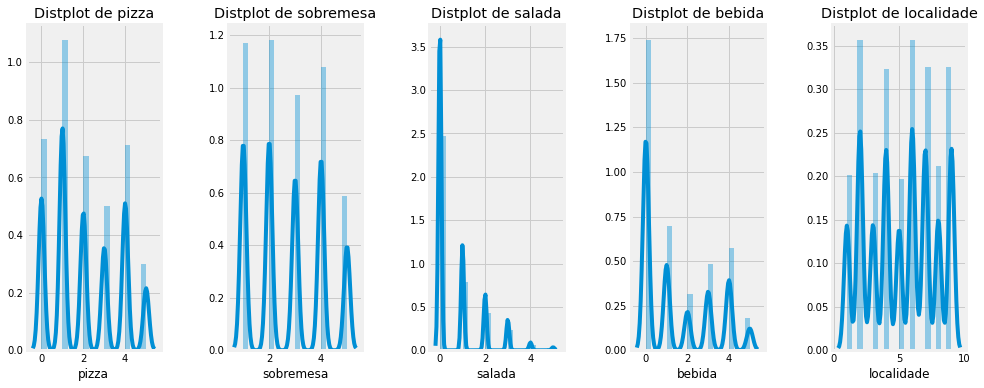

In [20]:
# Distribuição dos itens pedidos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 6))

# Inicializa o contador
n = 0 

# Loop pelas colunas
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df_item_pedidos[x] , bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()

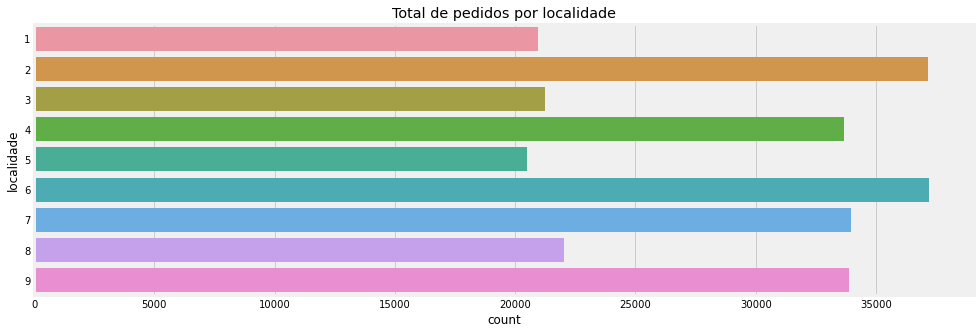

In [21]:
# Total de pedidos por localidade
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'localidade' , data = df_item_pedidos)
plt.title('Total de pedidos por localidade')
plt.show()

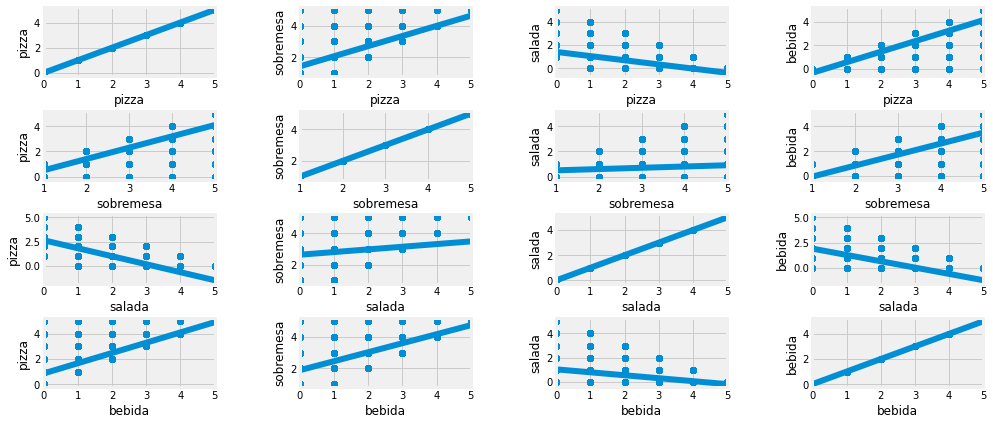

In [22]:
# Relação Entre os Atributos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 7))

# Inicializa o contador
n = 0 

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
        n += 1
        plt.subplot(4 , 4 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df_item_pedidos)
        plt.ylabel(y)
plt.show()

<h3 style="background:#6A9662; color:#FFF; padding:5px;">6. Análise de segmentação</h3>

#### Segmentação 1:  Campanhas de marketing para aumentar as vendas de pizza nos meses de Janeiro, Fevereiro, Junho e Julho.

#### Segregando o Dataframe

In [23]:
# Obtendo dados apenas para os meses de Janeiro, Fevereiro, Junho e Julho
df3_JanFevJunJul = df_item_pedidos[df_item_pedidos.mes.between('01', '02', inclusive = True) |
                                   df_item_pedidos.mes.between('06', '07', inclusive = True)]

In [24]:
# Usando apenas as variáveis solicitadas para a clusterização
df3_JanFevJunJul = df3_JanFevJunJul[['bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

In [25]:
df3_JanFevJunJul.head(4)

,bebida,pizza,sobremesa,salada,localidade
0,0.0,1.0,1.0,0.0,9
1,0.0,1.0,1.0,0.0,9
4,4.0,4.0,5.0,1.0,9
5,4.0,4.0,5.0,1.0,9


In [26]:
df3_JanFevJunJul.describe()

,bebida,pizza,sobremesa,salada,localidade
count,86377.000000,86377.000000,86377.000000,86377.000000,86377.000000
mean,1.493291,2.066025,2.740950,0.674925,5.126955
std,1.658314,1.578048,1.339753,1.035889,2.546570
min,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,2.000000,0.000000,3.000000
50%,1.000000,2.000000,3.000000,0.000000,5.000000
75%,3.000000,4.000000,4.000000,1.000000,7.000000
max,5.000000,5.000000,5.000000,5.000000,9.000000


In [27]:
df3_JanFevJunJul.corr()

,bebida,pizza,sobremesa,salada,localidade
bebida,1.000000,0.855761,0.710677,-0.384500,0.300122
pizza,0.855761,1.000000,0.759652,-0.540889,0.235604
sobremesa,0.710677,0.759652,1.000000,0.136100,0.203535
salada,-0.384500,-0.540889,0.136100,1.000000,-0.095675
localidade,0.300122,0.235604,0.203535,-0.095675,1.000000


Podemos verificar que Pizza e Sobremesa possuem uma alta correlação positiva, desta forma vamos explorar essas variáveis

In [28]:
# Usaremos duas variáveis para a segmentação 1
X1 = df3_JanFevJunJul[['pizza' , 'sobremesa']].iloc[: , :].values

In [29]:
# Lista do WCSS
wcss_X1 = []

In [30]:
# Loop para testar os valores de K
for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

#### Verificando WCSS na Curva de Elbow

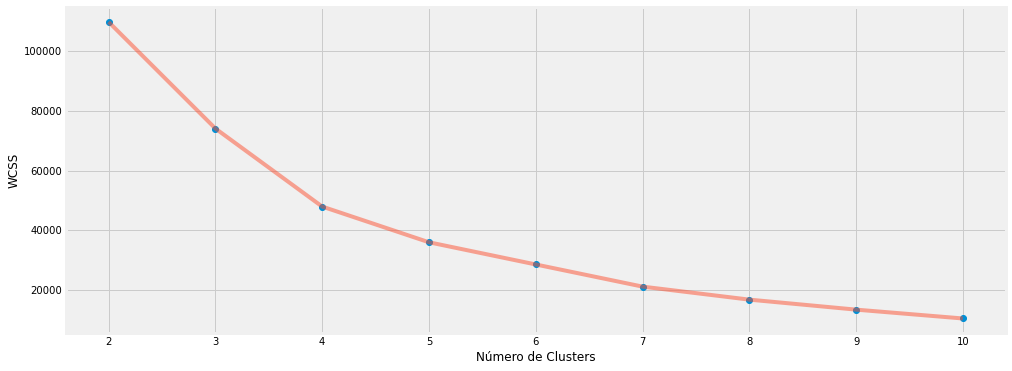

In [31]:
# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , wcss_X1 , 'o')
plt.plot(np.arange(2 , 11) , wcss_X1 , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('WCSS')
plt.show()

#### Construindo e treinando o modelo e plotando os resultados

In [32]:
# Criação do modelo
modelo_seg1 = KMeans(n_clusters = 3, 
                     init = 'k-means++', 
                     n_init = 10, 
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan')

In [33]:
# Treinamento do modelo
modelo_seg1.fit(X1)

KMeans(algorithm='elkan', n_clusters=3, random_state=111)

In [34]:
# Extração dos labels
labels1 = modelo_seg1.labels_
labels1

array([2, 2, 1, ..., 1, 0, 0])

In [35]:
# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

array([[1.99701836, 2.71660021],
       [4.08139308, 4.35018135],
       [0.55366425, 1.50734065]])

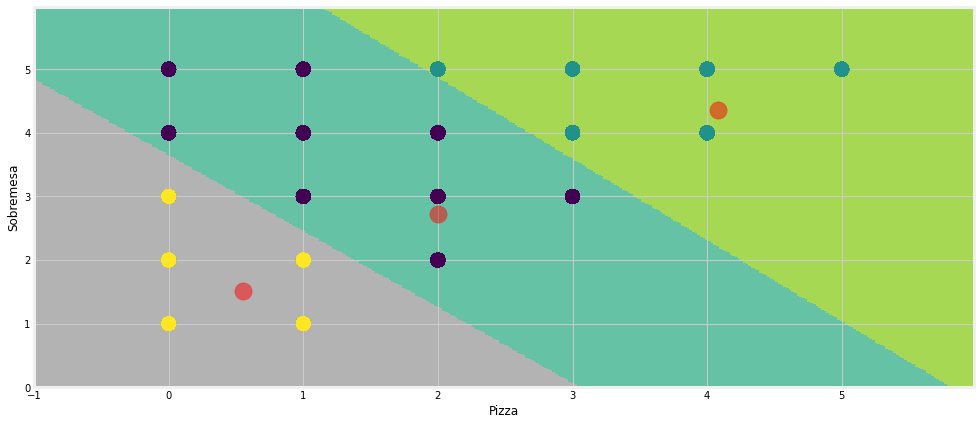

In [36]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Set2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'sobremesa', data = df3_JanFevJunJul, c = labels1, s = 200 )
plt.scatter(x = centroids1[: , 0], y =  centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

<p id="division_1">Segmentação para campanha 1 - aumentar as vendas de pizza nos meses de Janeiro, Fevereiro, Junho e Julho</p>

#### Interpretação:

- O ponto vermelho é o centróide de cada cluster (segmento).
- No cluster 1 (área em cinza) temos os clientes que pediram menos Pizzas e menos Sobremesas.
- No cluster 2 (área em verde escuro) temos os clientes que pediram até 3 Pizzas e até 3 Sobremesas.
- No cluster 3 (área em verde claro) estão clientes que pediram mais Pizzas e mais Sobremesas.

#### Análise:
Os clusters 1 e 3 são de clientes com comportamentos opostos. A equipe de Marketing poderia concentrar os esforços nos clientes do cluster 2, pois são clientes que compram Pizzas e Sobremesas e, portanto, poderiam responder adequadamente a uma promoção do tipo compre 2 pizzas e ganhe uma sobremesa.

----------

#### Segmentação 2:  Campanhas de marketing para horários diferentes.

#### Segregando e ajustando o Dataframe

In [37]:
# Obtenndo as colunas de interesse
df4_periodos = df_item_pedidos[['bebida', 'pizza', 'sobremesa', 'salada', 'horario']]
# Sumarizando o total de produtos pedidos
df4_periodos['total'] = df4_periodos.iloc[:,0:4].sum(axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [38]:
df4_periodos.head(5)

,bebida,pizza,sobremesa,salada,horario,total
0,0.0,1.0,1.0,0.0,00:48:00,2.0
1,0.0,1.0,1.0,0.0,00:48:00,2.0
2,0.0,2.0,2.0,0.0,00:08:00,4.0
3,0.0,2.0,2.0,0.0,00:08:00,4.0
4,4.0,4.0,5.0,1.0,19:24:00,14.0


In [39]:
df4_periodos.dtypes

bebida       float64
pizza        float64
sobremesa    float64
salada       float64
horario       object
total        float64
dtype: object

In [40]:
# Criando os períodos 1 - manhã, 2 - tarde, 3 - noite, 4 - madrugada
df4_periodos['periodo'] = int(0)
df4_periodos.loc[df4_periodos.horario.between(datetime.datetime.strptime("06:00:00","%H:%M:%S").time(),
                                              datetime.datetime.strptime("12:00:00","%H:%M:%S").time()),
                'periodo'] = 1

df4_periodos.loc[df4_periodos.horario.between(datetime.datetime.strptime("12:00:00","%H:%M:%S").time(),
                                              datetime.datetime.strptime("18:00:00","%H:%M:%S").time()),
                'periodo'] = 2

df4_periodos.loc[df4_periodos.horario.between(datetime.datetime.strptime("18:00:00","%H:%M:%S").time(),
                                              datetime.datetime.strptime("23:59:59","%H:%M:%S").time()),
                'periodo'] = 3

df4_periodos.loc[df4_periodos.horario.between(datetime.datetime.strptime("00:00:00","%H:%M:%S").time(),
                                              datetime.datetime.strptime("06:00:00","%H:%M:%S").time()),
                'periodo'] = 4

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [41]:
# Verificando se todos os períodos foram configurados
df4_periodos.periodo.unique()

array([4, 3, 2, 1], dtype=int64)

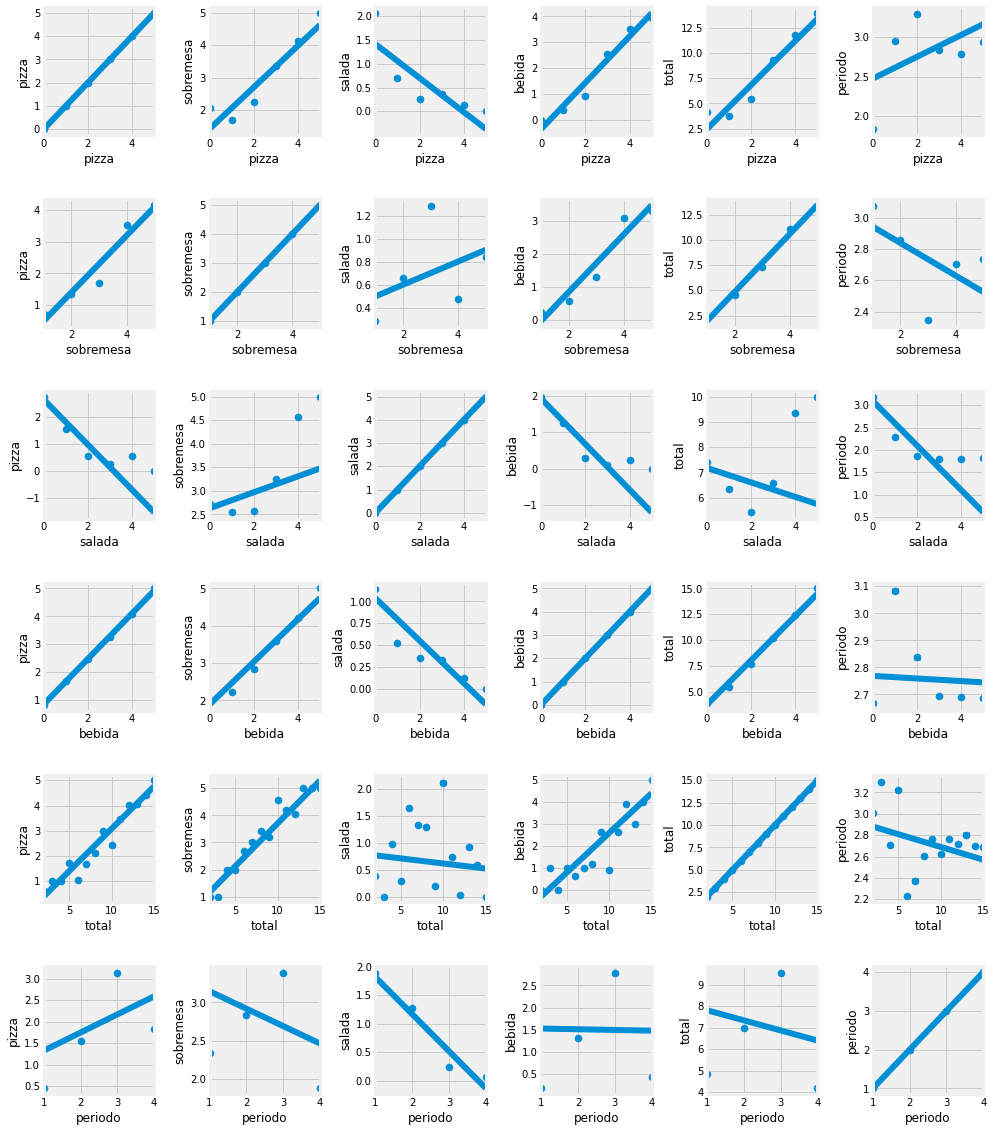

In [43]:
# Relação Entre os Atributos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 20))

# Inicializa o contador
n = 0 

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'total', 'periodo']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'total', 'periodo']:
        n += 1
        plt.subplot(6 , 6 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df4_periodos, x_jitter=.1, x_estimator=np.mean)
        plt.ylabel(y)
plt.show()

#### Criando e treinando o modelo

In [44]:
# Usaremos duas variáveis para a segmentação 2 (parece haver mais correlação entre essas variáveis)
X2 = df4_periodos[['pizza' , 'periodo']].iloc[: , :].values

In [45]:
# Criação do modelo
modelo_seg2 = KMeans(n_clusters = 4, 
                     init = 'k-means++', 
                     n_init = 10, 
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan')

In [46]:
# Treinamento do modelo
modelo_seg2.fit(X2)

KMeans(algorithm='elkan', n_clusters=4, random_state=111)

#### Plotando o Meshgrid para visualização dos clusters

In [47]:
# Extração dos labels
labels2 = modelo_seg2.labels_
labels2

array([2, 2, 2, ..., 2, 2, 2])

In [48]:
# Extração dos centróides
centroids2 = modelo_seg2.cluster_centers_
centroids2

array([[0.39669476, 1.76879115],
       [2.61200314, 2.76972453],
       [1.32488804, 3.83616036],
       [4.2956785 , 2.83611595]])

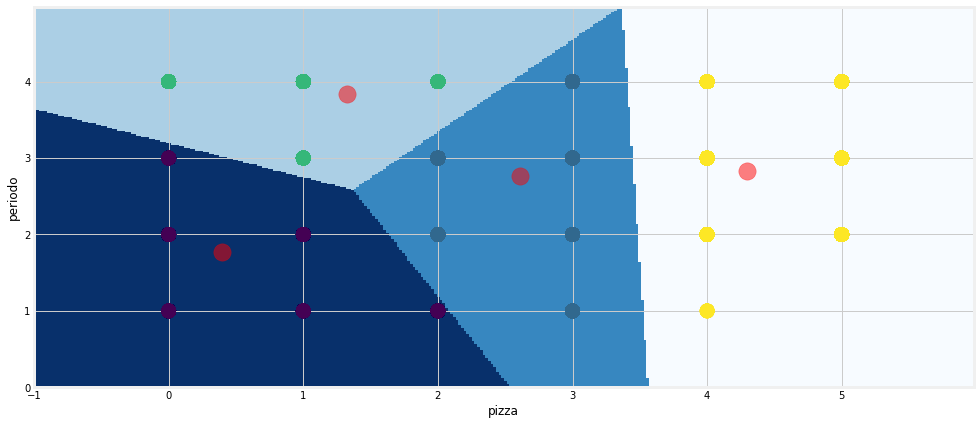

In [49]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg2.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Blues_r, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'periodo', data = df4_periodos, c = labels2, s = 200 )
plt.scatter(x = centroids2[: , 0], y =  centroids2[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('pizza')
plt.ylabel('periodo')
plt.show()

<p id="division_2">Segmentação para campanha 2 - maximizar vendas de pizza por período: manhã, tarde, noite e madrugada</p>

#### Interpretação:

- O ponto vermelho é o centróide de cada cluster (segmento).
- No cluster 1 (área em azul claro) temos os clientes que pediram menos Pizzas de madrugada.
- No cluster 2 (área em azul escuro) temos os clientes que pediram até 2 Pizzas em todos períodos, exceto madrugada.
- No cluster 3 (área em azul médio) estão clientes que pediram 3 Pizzas em quaisquer período.
- No cluster 4 (área em branco) estão os clientes que mais pedem pizzas (4 e 5) para qualquer período

#### Análise:
O cluster 3 possuem clientes potenciais para uma campanha para aumento de vendas. A equipe de Marketing poderia concentrar os esforços nos clientes deste cluster, com uma promoção do tipo compre 4 pizzas e ganhe uma sobremesa, por exemplo

<h3 style="background:#6A9662; color:#FFF; padding:5px;">7. Relatório final</h3>

> Após análises dos dados temos as seguintes considerações para atendimento dos objetivos:
- Criar três campanhas de marketing para aumentar as vendas de pizza nos meses de Janeiro, Fevereiro, Junho e Julho.
    - O [modelo 1](#division_1) nos possibilita criar as campanhas com base nos habitos de consumo dos clientes, referenciando a sobremesa como sendo um produto coadjuvante a fim de impulsionar vendas de pizza.
- Implantar 4 campanhas, usando a variável períodos (manhã, tarde, noite e madrugada) respectivamente a fim de maximizar a venda de pizzas.
    - O [modelo 2](#division_2) nos sugere que a aboragem por período não seria a mais indicada, carecendo de outros elementos a fim de atender a demanda, por exemplo valorização dos itens de consumo.